# Android Data from PlayStore

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv('googleplaystore.csv')
df_user_reviews = pd.read_csv('googleplaystore_user_reviews.csv')
df.head()
df_user_reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


## Preprocessing
Many columns need preformatting to be able to use them in any machine learning models. They should be converted to numbers.

In [4]:
# preformat #Installs
df = df[df['Installs'] != 'Free']
new_df = df['Installs'].map(lambda s : s[:-1].replace(',',''))
new_df[new_df == ''] = 0
new_df.astype(int).unique()
df['Installs'] = new_df.astype(int)

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0])

In [5]:
# preformat #Reviews
df['Reviews'] = df['Reviews'].astype(int)

In [6]:
# Other preformat cells here !!!!!!!

## Feature engineering
Features below are derived from the original features of data

In [7]:
# preformat #Size
# np.sort(df['Size'].unique())
def size_transform(size):
    if size == 'Varies with device':
        return 1
    unit = size[-1]
    number = float(size[:-1])
    if unit == 'M':
        return number * 1024 * 1024
    if unit == 'k':
        return number * 1024
df['Size'] = df['Size'].apply(size_transform)


In [8]:
# preprocess #Last Updated
# keep only the year
df['last_year_updated'] = df['Last Updated'].apply(lambda s : s[-4:]).astype(int)

In [9]:
# preprocess #App Name
# keep the word count of the app name
df['appname_wc'] = df['App'].apply(lambda s : len(s.replace('&','').replace('-', '').split()))

In [10]:
# preprocess # CurrentVer and #AndroidVer
def vs_transform(version):
    if version == 'Varies with device':
        return -1
    if version == np.NaN or version == np.nan:
        return np.nan
    return version[0]
# there are some edge cases that still need to be cared about
df['Current Ver'].astype(str).sort_values()[-1600:]
# df['major_version'] = df['Current Ver'].astype(str).apply(vs_transform).astype(int)
# df['Android Ver'].astype(str).apply(vs_transform).astype(int)

10662                                   Android 3.0 - 2015
10650                                   Android 3.0 - 2017
8145                                    Android 3.1 - 2015
8151                                    Android 3.1 - 2017
7509                                         App copyright
6195                                             Arrow-202
6437                     BL ONLINE PERSONAL TRAINING 7.9.0
9644                                            BlueOrange
7507                                     Bowser4Craigslist
9310                                              Build 12
9298                                              Build 54
7500                    CL Pro for Craigslist - Canada 150
7534                                    CL Strength 7.12.1
1042                                      Cannonau 3.11.11
7510                                             Copyright
5716                                             Cow V3.11
6039                                             Cow V3.

In [11]:
# drop columns not used
orig_df = df
drop_columns = ['App', 'Last Updated', 'Current Ver', 'Android Ver']
df.drop(columns = drop_columns, inplace = True)

In [12]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,last_year_updated,appname_wc
0,ART_AND_DESIGN,4.1,159,19922944.0,10000,Free,0,Everyone,Art & Design,2018,6
1,ART_AND_DESIGN,3.9,967,14680064.0,500000,Free,0,Everyone,Art & Design;Pretend Play,2018,3
2,ART_AND_DESIGN,4.7,87510,9122611.2,5000000,Free,0,Everyone,Art & Design,2018,10
3,ART_AND_DESIGN,4.5,215644,26214400.0,50000000,Free,0,Teen,Art & Design,2018,3
4,ART_AND_DESIGN,4.3,967,2936012.8,100000,Free,0,Everyone,Art & Design;Creativity,2018,6


## Missing values

Rating column has 10% missing values. To not lose the data, we try and predict its values using the other features.

In [13]:
# check for null values
# rating has a few
df.isnull().sum()

Category                0
Rating               1474
Reviews                 0
Size                    0
Installs                0
Type                    1
Price                   0
Content Rating          0
Genres                  0
last_year_updated       0
appname_wc              0
dtype: int64

In [14]:
# get the rows with null ratings out, to predict them later
df['rating_complete'] = df['Rating']
to_predict_rating = df[df['rating_complete'].isnull()]
# dfn - df without nulls
dfn = df[~df['rating_complete'].isnull()]

# Exploratory plots
We plot some data, to see its ranges

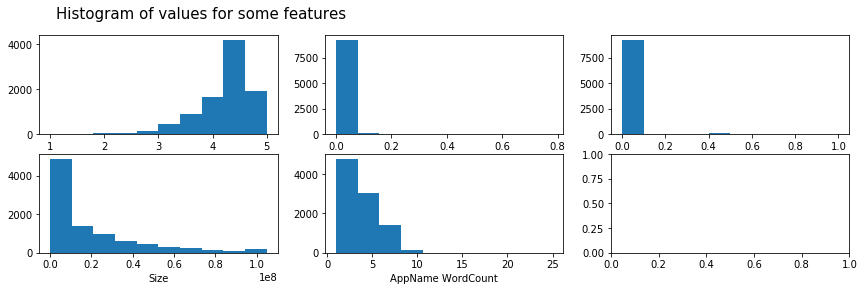

In [15]:
fig, axs = plt.subplots(nrows = 2, ncols = 3);
fig.suptitle('Histogram of values for some features', fontsize = 15);
axs[0][0].hist(dfn['rating_complete']);
axs[0][0].set_xlabel('Rating');
axs[0][1].hist(dfn['Reviews']);
axs[0][1].set_xlabel('Reviews');
axs[0][2].hist(dfn['Installs']);
axs[0][2].set_xlabel('Installs');
axs[1][0].hist(dfn['Size']);
axs[1][0].set_xlabel('Size');
axs[1][1].hist(dfn['appname_wc']);
axs[1][1].set_xlabel('AppName WordCount');
fig.subplots_adjust(right = 2);

In [248]:
# Because not all features are preprocessed yet, we got only to use 'Reviews' and 'Installs'. 
# This led to terrible results, like an R squared error of 0.002
# But below you can find an example that find a linear model between 'Reviews' and 'Installs' that works well
# It predicts number of 'Reviews' based on 'Installs' with an R squared error of 0.92 

# A linear model

In [16]:
# we use .values because the ML models work with numpy arrays, not pandas dataframes
Y = dfn['Reviews'].values
X = dfn[['Installs']].values

In [252]:
# In some cases we may need to scale data. There are many types of scallers in the preprocessing module. 
# Here is an example

# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# X = scaler.fit_transform(X)
# Y = scaler.fit_transform(Y.reshape(-1,1)).squeeze()

In [17]:
# when creating a ML model, we split data in train and test 
# we train the model on the train data and evaluate its performance on the test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [18]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train R squared : 0.3746
Test R squared : 0.5583


In [19]:
X_log = np.log(X)
Y_log = np.log(Y)
x_train, x_test, y_train, y_test = train_test_split(X_log, Y_log, test_size = 0.2, random_state = 42)

In [ ]:
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

In [ ]:
dfn.columns
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2);
fig.suptitle('Linear model between Reviews and Installs', fontsize = 15)
fig.subplots_adjust(right = 2)
ax1.set_title('Original data')
ax1.scatter(X, Y);
ax1.set_xlabel('Installs');
ax1.set_ylabel('Reviews');
ax2.set_title('Log data')
ax2.scatter(X_log[:,0], Y_log);
ax2.set_xlabel('Installs_log')
ax2.set_ylabel('Reviews_log');
y_pred = lr.predict(X_log)
ax2.plot(X_log[:,0], y_pred, c = 'red');

## Trying other modules

In [24]:
Y = dfn['rating_complete'].values
X = dfn[['Size', 'Installs', 'Reviews', 'last_year_updated', 'appname_wc']]

In [29]:
from sklearn import svm
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
svr = svm.SVR()
svr.fit(x_train, y_train)
svr.score(x_train, y_train)
svr.score(x_test, y_test)


/home/bob/Programs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

0.8440251767950099

0.026713445482874243